## WfCommons to QUBO: Dealing with inequality constraints 

An inequality constraint:  $$h(x) = \sum_{i} l_i x_i  - C \leq 0$$

1) Using slacks: 

$$ \big(\sum_{i} l_i x_i + \sum_{k} 2^k s_k - C \big)^2 = 0  $$


2. Using the **unbalanced function** (A. Montanez-Barrera et al., 2022) :

$$ e^{h(x)} \approx 1 + h(x) + \frac{1}{2} h(x)^2 $$

$$ \lambda_1 \big(\sum_{i} l_i x_i - C\big) + \lambda_2 \big(\sum_{i} l_i x_i - C\big)^2 $$

2. Using the **unbalanced function** (A. Montanez-Barrera et al., 2022) :

$$ e^{h(x)} \approx 1 + h(x) + \frac{1}{2} h(x)^2 $$

$$ \lambda_1 \big(\sum_{i} l_i x_i - C\big) + \lambda_2 \big(\sum_{i} l_i x_i - C\big)^2 $$

In [1]:
import numpy as np
params_config = {
    'angles': [[1.9482, 4.2254, 4.1086, 5.7801, 4.1416, 3.8738],   # gammas
               [0.9043, 2.5178, 1.7931, 2.4655, 1.3755, 1.0457]],  # betas
    'hyper_args': [1, 2, 2], # obj. function, lambda_1, lambda_2
}

In [2]:
from QHyper.solvers import VQA, solver_from_config

solver_config = {
    "problem": {
        "type": "workflow_scheduling",
        "encoding": "binary",
        "tasks_file": "workflows_data/workflows/3_tasks_1_path.json",
        "machines_file": "workflows_data/machines/4_machines.json",
        "deadline": 13,
    },
    "solver": {
        "type": "vqa",
        "pqc": {
            "type": "sim_hamiltonian_qaoa",
            "layers": 6,
            "optimizer": "adam",
            "optimizer_args": {
                "stepsize": 0.00045,
                "steps": 1,
                "verbose": True,
            },
            "backend": "lightning.qubit",
        },
        "params_inits": params_config
    }
}

vqa = solver_from_config(solver_config)

In [3]:
import pennylane as qml

dev = qml.device("lightning.qubit", wires=[str(x) for x in vqa.problem.variables] + [f"a{i}" for i in range(3 + 2 + len(vqa.problem.variables))])

vqa.pqc.dev = dev
test_circuit = vqa.pqc.get_expval_circuit(vqa.problem, list(vqa.params_inits['hyper_args']))

# cost_operator = vqa.pqc.create_qubo(vqa.problem, list(vqa.params_inits['hyper_args']))
# @qml.qnode(dev)
# def test_circuit(params):
#     vqa.pqc._circuit(vqa.problem, params, cost_operator)
#     return qml.state()

In [4]:
print(test_circuit(vqa.params_inits['angles']))

SimHamiltonianQAOA 6 lightning.qubit
AAAAAAAAAAAAAAAAAAAAAAAAAA
BBBBBBBBBBBBBBBBBBBBBBBBBBB
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
AAAAAAAAAAAAAAAAAAAAAAAAAA
BBBBBBBBBBBBBBBBBBBBBBBBBBB
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCC

KeyboardInterrupt: 

In [ ]:
from QHyper.util import Operator

variables_n = len(vqa.problem.variables)
#x = 0b100000
for ox in range(2**variables_n):
    x = list(map(int, bin(ox)[2:].zfill(variables_n)))[::-1]
    values = {str(var): x[i] for i,var in enumerate(vqa.problem.variables)}

    valid = True
    for constraint in vqa.problem.constraints:
        res = 0
        for vars, coeff in constraint.lhs.items():
            res += coeff * np.prod([values[var] for var in vars])

        if constraint.operator == Operator.LE:
            valid = res <= constraint.rhs
        elif constraint.operator == Operator.GE:
            valid = res >= constraint.rhs
        
        if not valid:
            break
    
    if not valid:
        continue

    res = -8*values['x0']*values['x1'] + 2*values['x0'] + 2*values['x1'] - 4*values['x2']*values['x3'] + values['x2'] + values['x3'] - 16*values['x4']*values['x5'] + 4*values['x4'] + 4*values['x5'] + 21
    print(bin(ox)[2:].zfill(variables_n), res)

#vqa.problem.objective_function.as_polynomial()

# for constraint in vqa.problem.constraints:
#     res = 0
#     for vars, coeff in constraint.lhs.items():
#         res += coeff * np.prod([values[var] for var in vars])

#     if constraint.operator == Operator.LE:
#         print(res, "<=", constraint.rhs, ":", res <= constraint.rhs)
#     elif constraint.operator == Operator.GE:
#         print(res, ">=", constraint.rhs, ":", res >= constraint.rhs)

010010 27
010110 28
011001 28
011010 28
100000 25
100001 27
100010 27
100100 26
100101 28
100110 28
101000 26
101001 28
101010 28


In [ ]:
import pennylane as qml
import pennylane.numpy as np

qml.grad(vqa.pqc.get_expval_circuit(vqa.problem, params_config['hyper_args']))(np.array(params_config['angles']))

In [ ]:
vqa.pqc.get_expval_circuit(vqa.problem, params_config['hyper_args'])(np.array(params_config['angles']))

In [ ]:
opt = qml.AdamOptimizer()
theta_new = opt.step(vqa.pqc.get_expval_circuit(vqa.problem, params_config['hyper_args']), np.array(params_config['angles']))
theta_new

In [13]:
solver_results = vqa.solve()

SimHamiltonianQAOA 6 lightning.qubit
Step 1/1: 27.23076923069155
SimHamiltonianQAOA 6 lightning.qubit


WireError: Wire with label a1 not found in <Wires = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']>.

<Axes: xlabel='index', ylabel='value'>

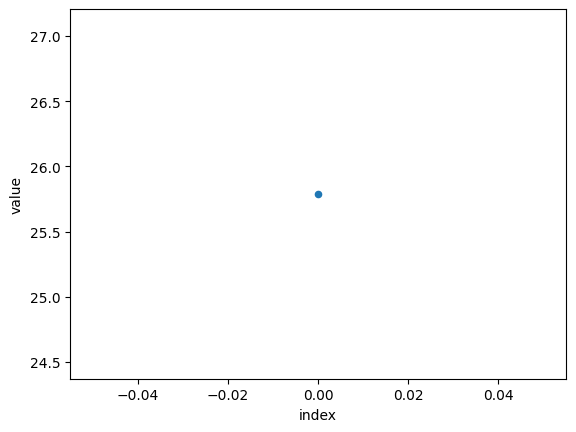

In [ ]:
import pandas as pd

pd.DataFrame(solver_results.history[0]).reset_index().plot(x='index',y='value', kind='scatter')

In [ ]:
print(f"Best params: {solver_results.params}")

Best params: {'angles': tensor([[1.90240071, 4.1802942 , 4.14856017, 5.7482359 , 4.09994406,
         3.83450025],
        [0.89295476, 2.55770442, 1.82959608, 2.49176822, 1.34016335,
         1.08143327]], requires_grad=True), 'hyper_args': tensor([1, 2, 2], requires_grad=True)}


In [ ]:
from QHyper.util import (
    weighted_avg_evaluation, sort_solver_results, add_evaluation_to_results)

# Evaluate results with weighted average evaluation
print("Evaluation:")
print(weighted_avg_evaluation(
    solver_results.results_probabilities, vqa.problem.get_score,
    penalty=0, limit_results=20, normalize=True
))
print("Sort results:")
sorted_results = sort_solver_results(
    solver_results.results_probabilities, limit_results=20)

# Add evaluation to results
results_with_evaluation = add_evaluation_to_results(
    sorted_results, vqa.problem.get_score, penalty=0)

for result, (probability, evaluation) in results_with_evaluation.items():
    print(f"Result: {result}, "
          f"\t Prob: {probability:.5}, "
          f"\t Evaluation: {evaluation}")

Evaluation:
25.641779768292206
Sort results:
Result: 000001, 	 Prob: 0.40823, 	 Evaluation: 25.0
Result: 001001, 	 Prob: 0.28299, 	 Evaluation: 26.0
Result: 000101, 	 Prob: 0.28299, 	 Evaluation: 26.0
Result: 010101, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 010110, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 011001, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 011010, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 100101, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 100110, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 101001, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 010001, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 010010, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 100001, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 000110, 	 Prob: 4.5386e-31, 	 Evaluation: 0
Result: 000010, 	 Prob: 4.0017e-31, 	 Evaluation: 0
Result: 001011, 	 Prob: 2.4083e-31, 	 Evaluation: 0
Result: 000100, 	 Prob: 1.9277e-31, 	 Evaluation: 0
Result: 001101, 	 Prob: 1.798e-31, 	 Evaluation:

3_tasks_1_path
100 steps


Step 1/100: 25.968905774803304
Step 2/100: 25.96247836802759
Step 3/100: 25.956240732858326
Step 4/100: 25.950199566933627
Step 5/100: 25.944360737418947
Step 6/100: 25.938728969308432
Step 7/100: 25.93330744625486
Step 8/100: 25.9280973176079
Step 9/100: 25.923097132379045
Step 10/100: 25.9183022750492
Step 11/100: 25.91370455419189
Step 12/100: 25.909292150526607
Step 13/100: 25.90505009368018
Step 14/100: 25.90096127716746
Step 15/100: 25.89700781546321
Step 16/100: 25.893172414662633
Step 17/100: 25.88943943504043
Step 18/100: 25.88579546486404
Step 19/100: 25.882229421076893
Step 20/100: 25.87873232932199
Step 21/100: 25.87529696019702
Step 22/100: 25.8719174476026
Step 23/100: 25.868588951516337
Step 24/100: 25.86530738485753
Step 25/100: 25.86206920379774
...
Step 97/100: 25.65343702502367
Step 98/100: 25.650518023342087
Step 99/100: 25.647601797128527
Step 100/100: 25.644688867254033



Evaluation:
25.641779768292206
Sort results:
Result: 000001, 	 Prob: 0.40823, 	 Evaluation: 25.0
Result: 001001, 	 Prob: 0.28299, 	 Evaluation: 26.0
Result: 000101, 	 Prob: 0.28299, 	 Evaluation: 26.0
Result: 010101, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 010110, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 011001, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 011010, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 100101, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 100110, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 101001, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 010001, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 010010, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 100001, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 000110, 	 Prob: 4.5386e-31, 	 Evaluation: 0
Result: 000010, 	 Prob: 4.0017e-31, 	 Evaluation: 0
Result: 001011, 	 Prob: 2.4083e-31, 	 Evaluation: 0
Result: 000100, 	 Prob: 1.9277e-31, 	 Evaluation: 0
Result: 001101, 	 Prob: 1.798e-31, 	 Evaluation: 0
Result: 001010, 	 Prob: 8.3883e-32, 	 Evaluation: 0
Result: 001100, 	 Prob: 7.2327e-32, 	 Evaluation: 0

In [ ]:
solver_config = {
    "problem": {
        "type": "workflow_scheduling",
        "encoding": "one-hot",
        "tasks_file": "workflows_data/workflows/srasearch_22_tasks.json", 
        "machines_file": "workflows_data/machines/cyfronet.json",
        "deadline": 5000,
    },
    "solver": {
        "type": "cqm",
        "time": 10,
    }
}

cqm = solver_from_config(solver_config)

In [ ]:
result = cqm.solve()

In [ ]:
cqm.problem.decode_solution(result)

{'bowtie2-build_ID0000001': 'AresCpu',
 'bowtie2_ID0000021': 'AresGpu',
 'merge_ID0000022': 'ZeusCpu',
 'bowtie2_ID0000003': 'AresGpu',
 'fasterq-dump_ID0000004': 'AresGpu',
 'bowtie2_ID0000005': 'PrometeusGpu',
 'fasterq-dump_ID0000006': 'AresGpu',
 'bowtie2_ID0000007': 'PrometeusGpu',
 'fasterq-dump_ID0000008': 'AresGpu',
 'bowtie2_ID0000009': 'PrometeusGpu',
 'fasterq-dump_ID0000010': 'AresGpu',
 'bowtie2_ID0000011': 'PrometeusGpu',
 'fasterq-dump_ID0000012': 'AresGpu',
 'fasterq-dump_ID0000002': 'AresGpu',
 'bowtie2_ID0000013': 'PrometeusGpu',
 'fasterq-dump_ID0000014': 'AresGpu',
 'bowtie2_ID0000015': 'PrometeusGpu',
 'fasterq-dump_ID0000016': 'AresGpu',
 'bowtie2_ID0000017': 'AresGpu',
 'fasterq-dump_ID0000018': 'AresGpu',
 'bowtie2_ID0000019': 'PrometeusGpu',
 'fasterq-dump_ID0000020': 'AresGpu'}